In [1]:
"""
import tensorflow as tf

# Configure TensorFlow to use the Metal GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

"""

"\nimport tensorflow as tf\n\n# Configure TensorFlow to use the Metal GPU\nphysical_devices = tf.config.list_physical_devices('GPU')\nif len(physical_devices) > 0:\n    tf.config.experimental.set_memory_growth(physical_devices[0], True)\n    tf.config.set_visible_devices(physical_devices[0], 'GPU')\n\n"

In [2]:
"""
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras import backend as K

# Ensure TensorFlow uses the Metal API for GPU acceleration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)
        
K.set_image_data_format('channels_last')
"""

"\nimport h5py\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.initializers import RandomNormal\nfrom keras import backend as K\n\n# Ensure TensorFlow uses the Metal API for GPU acceleration\ngpus = tf.config.experimental.list_physical_devices('GPU')\nif gpus:\n    try:\n        for gpu in gpus:\n            tf.config.experimental.set_memory_growth(gpu, True)\n        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')\n    except RuntimeError as e:\n        print(e)\n        \nK.set_image_data_format('channels_last')\n"

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
"""
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
"""

'\nimport tensorflow as tf\nprint("Num GPUs Available: ", len(tf.config.list_physical_devices(\'GPU\')))\n'

(16338, 128, 128, 7)
Dataset contains 16338 images with 7 channels each, of size 128x128.


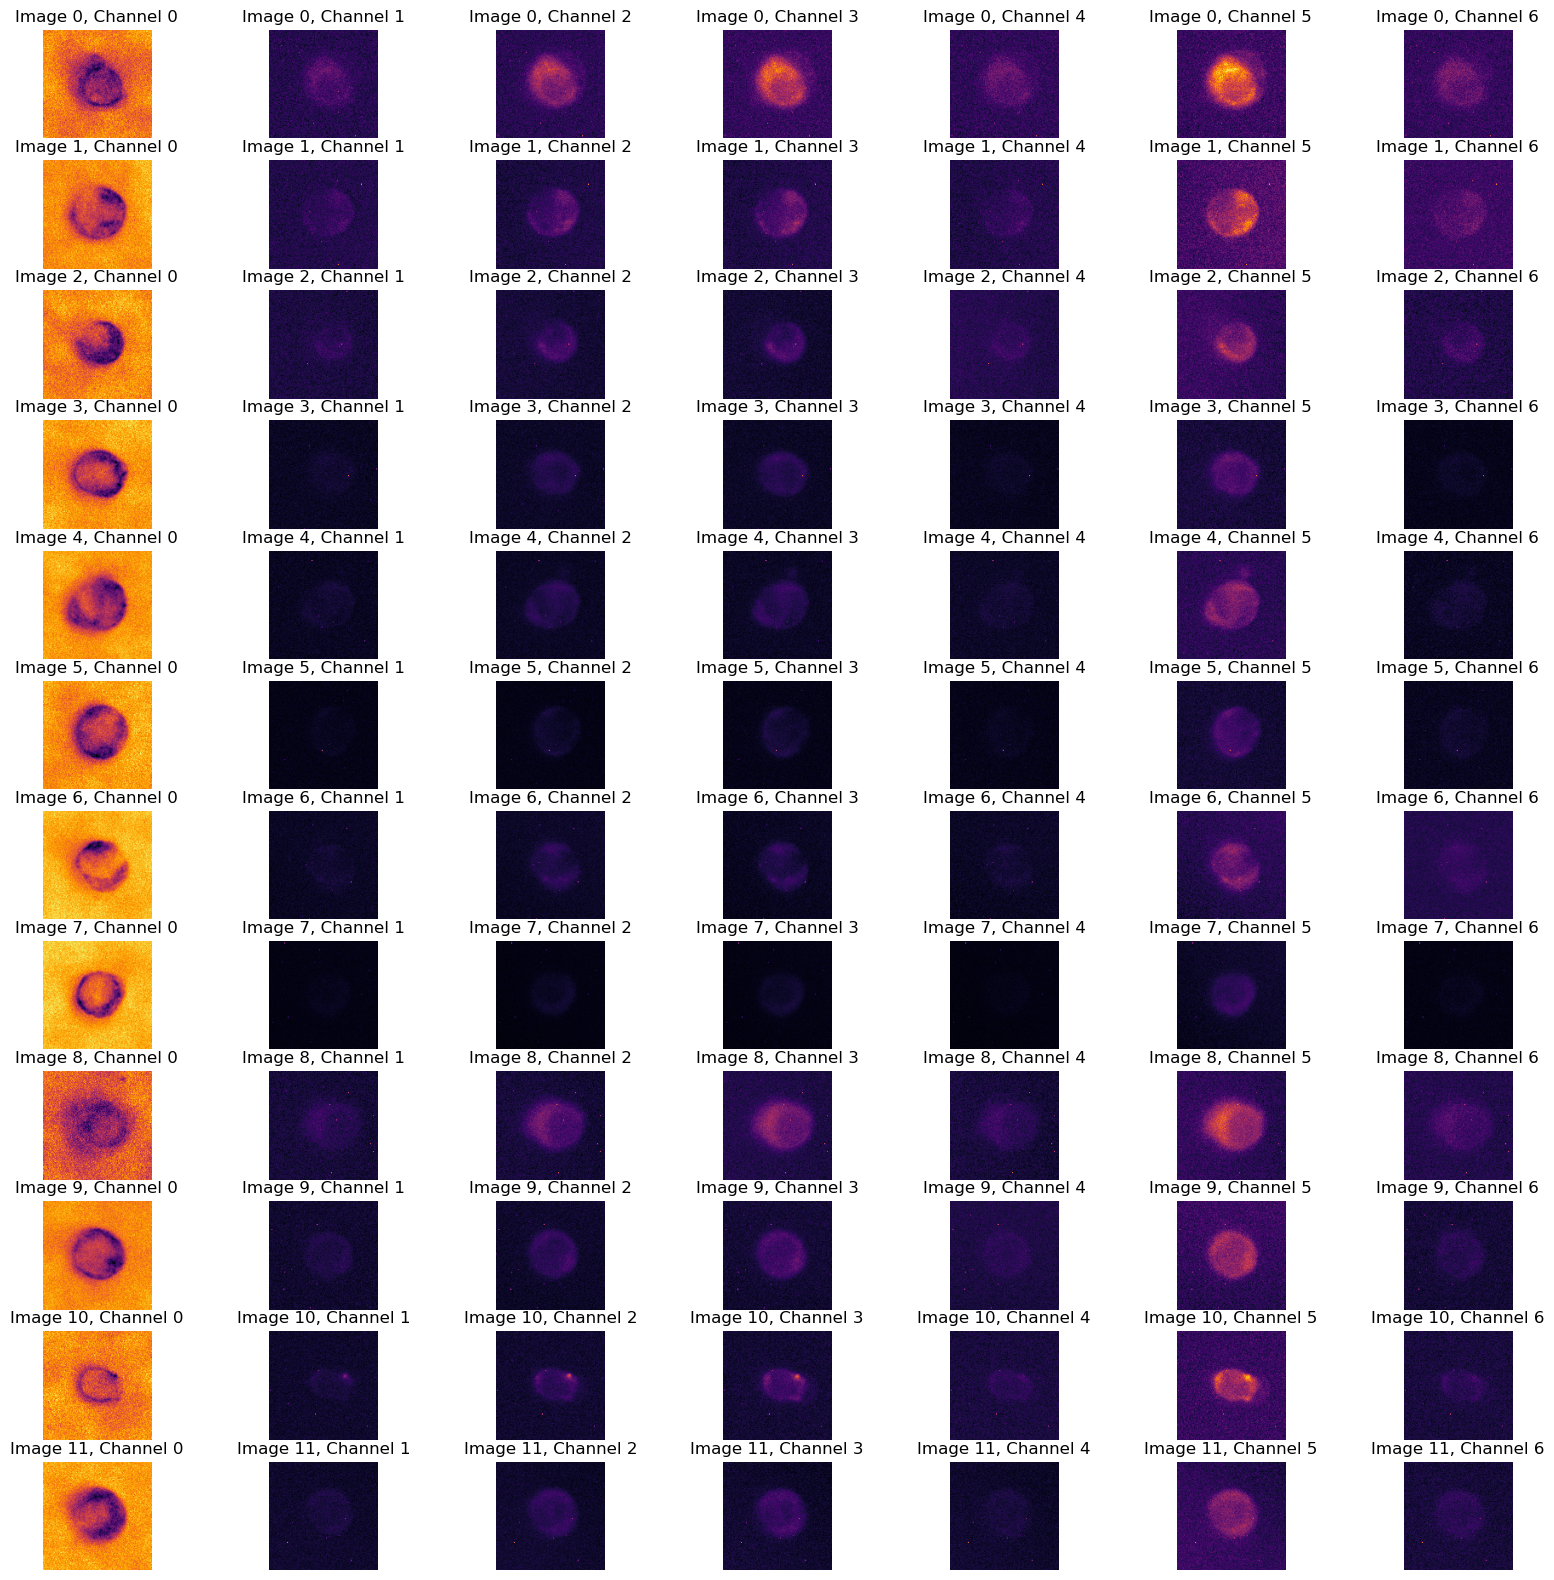

In [5]:
def display_transposedimages_from_hdf5(file_path, num_images_to_display=12):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(images_dataset.shape)
        
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")

        # Display the first few images
        
        plt.figure(figsize=(20, 20))
        for i in range(min(num_images_to_display, num_images)):
            for j in range(images_dataset.shape[-1]):  # Loop over channels in NHWC format
                img = images_dataset[i, :, :, j]
                plt.subplot(num_images_to_display, images_dataset.shape[-1], i * images_dataset.shape[-1] + j + 1)
                plt.imshow(img, cmap='inferno')
                plt.title(f'Image {i}, Channel {j}')
                plt.axis('off')
            
        plt.show()
        return images_dataset
 
output_file_path = 'fluor_images_transposed.h5'
images_dataset_transposed = display_transposedimages_from_hdf5(output_file_path)


In [6]:
from keras import backend as K
K.set_image_data_format('channels_last')

**PatchGAN Discriminator**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    
    # Expand dimensions of source image to match target image
    #expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                          #output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    
    # Expand dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model

    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    
    return model

# define image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# create the model
model = define_discriminator(input_shape_2d, output_shape_3d)

# summarize the model
model.summary()


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1, 1)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ lambda[0][0]      │
│                     │ 1, 6)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128,  │          0 │ lambda_1[0][0]    │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 12)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│                     │ 12, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64, 6, │      4,160 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64, 6, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32, 3, │    524,416 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32, 3, │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32, 3, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16, 2, │  2,097,408 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16, 2, │      1,024 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16, 2, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 1,   │  8,389,120 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 1,   │      2,048 │ conv3d_3[0][0]  

 Total params: 27,831,233 (106.17 MB)

 Trainable params: 27,828,417 (106.16 MB)

 Non-trainable params: 2,816 (11.00 KB)

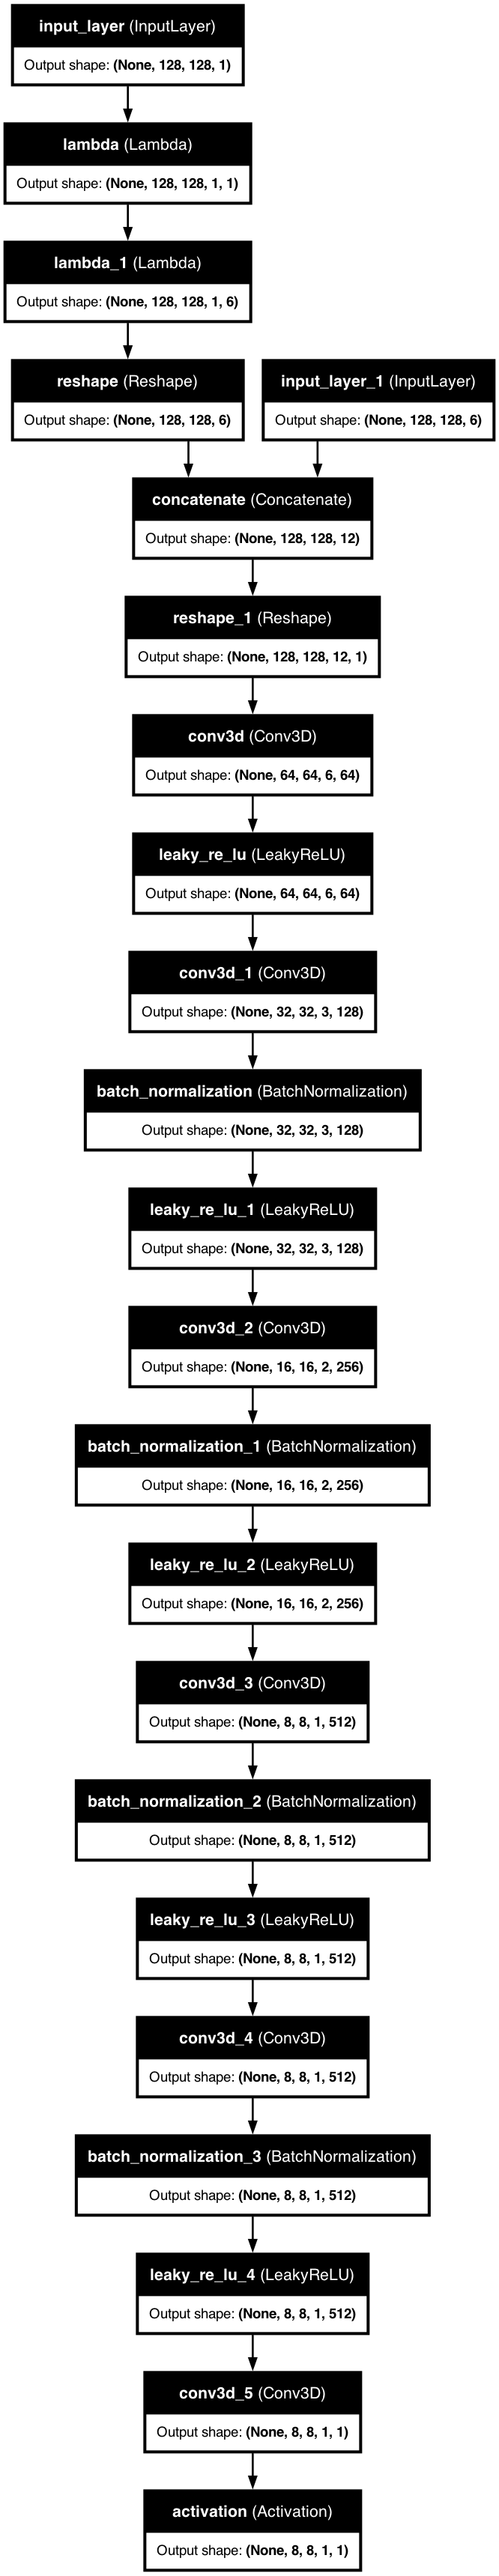

In [8]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

# U-Net Generator

In [9]:
# example of defining a u-net encoder-decoder generator model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    #d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define image shape
image_shape = (128, 128, 1)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,845,382 (159.63 MB)

 Trainable params: 41,837,574 (159.60 MB)

 Non-trainable params: 7,808 (30.50 KB)

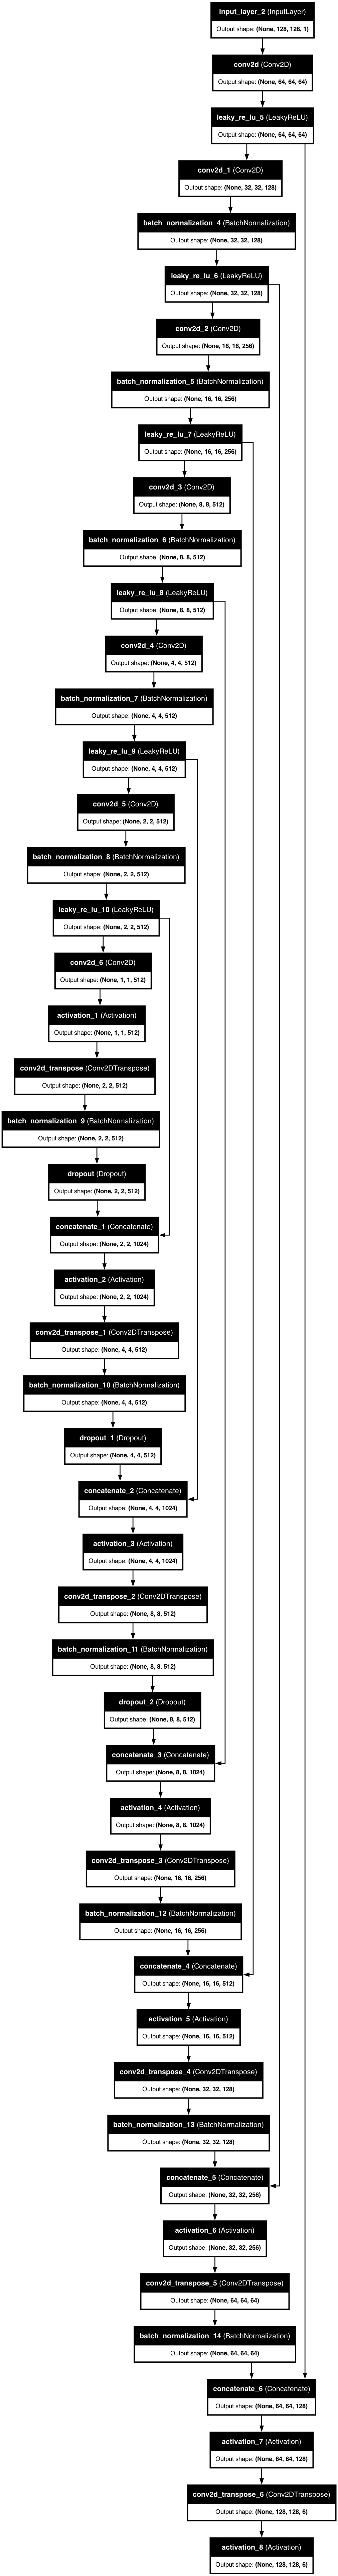

In [10]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [11]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
 # make weights in the discriminator not trainable
 for layer in d_model.layers:
     if not isinstance(layer, BatchNormalization):
         layer.trainable = False
 # define the source image
 in_src = Input(shape=image_shape)
 # connect the source image to the generator input
 gen_out = g_model(in_src)
 # connect the source input and generator output to the discriminator input
 dis_out = d_model([in_src, gen_out])
 # src image as input, generated image and classification output
 model = Model(in_src, [dis_out, gen_out])
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 return model

/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 41,845,382 │ input_layer_6[0]… │
│ (Functional)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 8, 8, 1,   │ 27,831,233 │ input_layer_6[0]… │
│ (Functional)        │ 1)                │            │ functional_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,676,615 (265.80 MB)

 Trainable params: 41,840,390 (159.61 MB)

 Non-trainable params: 27,836,225 (106.19 MB)

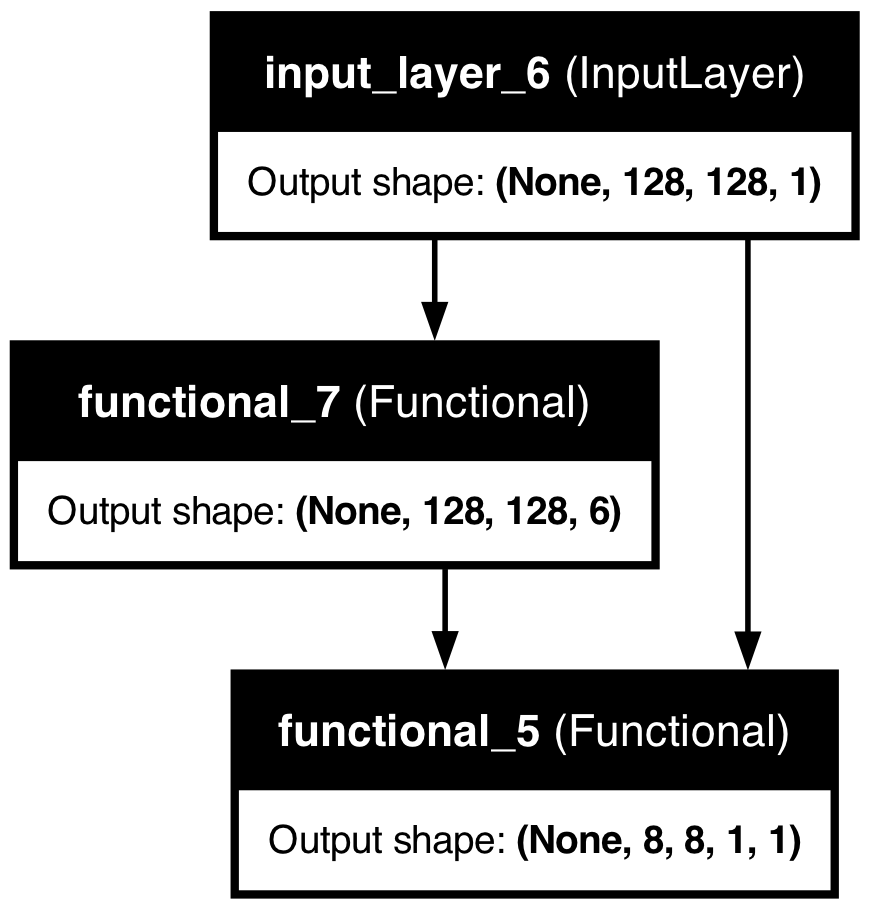

In [12]:
# define image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# define the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# Updating the model weights

In [13]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    # Convert the dataset to a numpy array
    #dataset_np = np.array(list(dataset.as_numpy_iterator()))
    
    # Check the dimensions of the dataset
    if dataset.shape != (16338, 128, 128, 7):
        raise ValueError(f'Dataset dimensions do not match the expected shape. Got {dataset.shape}')
    
    # Extract the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]
    
    # Extract the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]
    
    # Verify the shapes
    print("Brightfield images shape:", brightfield_images.shape)
    print("Fluorescence images shape:", fluorescence_images.shape)
    
    return brightfield_images, fluorescence_images




In [14]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # Reshape X1 to add channel dimension if necessary
    if len(X1.shape) == 3:
        X1 = X1.reshape(X1.shape + (1,))
        
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [15]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [16]:
def check_dataset_format(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(f"Dataset shape: {images_dataset.shape}")
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")
        
        # Verify the datatype
        datatype = images_dataset.dtype
        print(f"Image datatype: {datatype}")

        # Check if the dataset follows NHWC format
        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:
            print("Dataset follows NHWC format.")
        else:
            print("Dataset does not follow NHWC format.")
        
        return images_dataset

# Usage
file_path = 'fluor_images_transposed.h5'
images_dataset = check_dataset_format(file_path)

Dataset shape: (16338, 128, 128, 7)
Dataset contains 16338 images with 7 channels each, of size 128x128.
Image datatype: uint16
Dataset follows NHWC format.


In [17]:
n_batch = 128
n_patch = 8
print(images_dataset.shape[1:])
file_path = 'fluor_images_transposed.h5'

# Open the file and keep it open
f = h5py.File(file_path, 'r')

(128, 128, 7)


In [18]:
images_dataset = f['images']
"""
#images_dataset_np = np.array(list(images_dataset.as_numpy_iterator()))
print(images_dataset.shape[1:])
def create_dataset(images_dataset, batch_size):
    def preprocess(image):
        # Normalize the image
        image = tf.cast(image, tf.float32) / 127.5 - 1
        return image

    dataset = tf.data.Dataset.from_tensor_slices(images_dataset)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Use the dataset in your training loop
train_dataset = create_dataset(images_dataset, n_batch)
images_dataset = train_dataset
"""

'\n#images_dataset_np = np.array(list(images_dataset.as_numpy_iterator()))\nprint(images_dataset.shape[1:])\ndef create_dataset(images_dataset, batch_size):\n    def preprocess(image):\n        # Normalize the image\n        image = tf.cast(image, tf.float32) / 127.5 - 1\n        return image\n\n    dataset = tf.data.Dataset.from_tensor_slices(images_dataset)\n    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\n    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)\n    return dataset\n\n# Use the dataset in your training loop\ntrain_dataset = create_dataset(images_dataset, n_batch)\nimages_dataset = train_dataset\n'

In [19]:


# select a batch of real samples
[X_realA, X_realB], y_real = generate_real_samples(images_dataset, n_batch, n_patch)
print(X_realA.shape)
print(X_realB.shape)
print(y_real.shape)

Brightfield images shape: (16338, 128, 128)
Fluorescence images shape: (16338, 128, 128, 6)
trainA shape: (16338, 128, 128)
trainB shape: (16338, 128, 128, 6)
(128, 128, 128, 1)
(128, 128, 128, 6)
(128, 8, 8, 1)


In [20]:
...

# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


In [21]:
print("X_realA shape:", X_realA.shape)
print("X_realB shape:", X_realB.shape)
print("y_real shape:", y_real.shape)
print("X_fakeB shape:", X_fakeB.shape)
print("y_fake shape:", y_fake.shape)

X_realA shape: (128, 128, 128, 1)
X_realB shape: (128, 128, 128, 6)
y_real shape: (128, 8, 8, 1)
X_fakeB shape: (128, 128, 128, 6)
y_fake shape: (128, 8, 8, 1)


In [22]:
# Get the discriminator's output for the generated images
disc_generated_output = d_model([X_realA, X_fakeB])

In [23]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = False
# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)


In [24]:
# Assuming you have already defined and created the gan_model
# Define the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
gan_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])

X_realA = X_realA.astype(np.float32)
X_realB = X_realB.astype(np.float32)

X_realA = (X_realA - 127.5) / 127.5
X_realB = (X_realB - 127.5) / 127.5

# Now you can call train_on_batch
#g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
#print(f"Generator loss on fake samples: {g_loss}")

In [25]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, patch_shape, generator_model):
        self.dataset = dataset
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(dataset)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [26]:
# Assuming you have already defined and created the generator model (g_model)
batch_size = 128
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data
epochs = 25
data_gen = DataGenerator(images_dataset, batch_size, patch_shape, g_model)

# Example of using the data generator with a GAN model
for epoch in range(epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        # Train the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # Train the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")


Brightfield images shape: (16338, 128, 128)
Fluorescence images shape: (16338, 128, 128, 6)


ValueError: as_list() is not defined on an unknown TensorShape.

In [ ]:

plt.figure(figsize=(20, 20))

for j in range(X_realA.shape[-1]):
    img = X_realA[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')

plt.show()


In [ ]:

plt.figure(figsize=(20, 20))

for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')

plt.show()


In [ ]:
c